# 1. Deepfake Dataset - Exploration & Validation

**Objective:** This notebook is for exploring and validating the dataset of cropped faces generated by the `preprocess_videos.py` script.

We will:
1. Load the metadata CSV (`faces_labels_full.csv`).
2. Analyze the class distribution (Real vs. Fake).
3. Analyze the number of faces extracted per video.
4. Visualize sample images from each class to perform a quality check.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- Configuration ---
# Adjust this path if your notebook is in a different location relative to the data directory
DATA_DIR = os.path.join("..", "data")
METADATA_PATH = os.path.join(DATA_DIR, "faces_metadata.csv")
IMAGE_DIR = os.path.join(DATA_DIR, "frames_cropped_full")

## 1. Load Metadata

First, let's load the CSV file containing the metadata for each extracted face.

In [2]:
if not os.path.exists(METADATA_PATH):
    print(f"Error: Metadata file not found at {METADATA_PATH}")
    print("Please run the `scripts/preprocess_videos.py` script first.")
else:
    df = pd.read_csv(METADATA_PATH)
    print("Metadata loaded successfully!")
    df.info()
    print("\nFirst 5 rows:")
    display(df.head())

Metadata loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155711 entries, 0 to 155710
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   filename      155711 non-null  object
 1   label         155711 non-null  int64 
 2   video_name    155711 non-null  object
 3   frame_number  155711 non-null  int64 
 4   face_number   155711 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 5.9+ MB

First 5 rows:


,filename,label,video_name,frame_number,face_number
0,fake\01_02__exit_phone_room__YVGY8LOK_frame0_f...,1,01_02__exit_phone_room__YVGY8LOK,0,0
1,fake\01_02__exit_phone_room__YVGY8LOK_frame10_...,1,01_02__exit_phone_room__YVGY8LOK,10,0
2,fake\01_02__exit_phone_room__YVGY8LOK_frame20_...,1,01_02__exit_phone_room__YVGY8LOK,20,0
3,fake\01_02__exit_phone_room__YVGY8LOK_frame30_...,1,01_02__exit_phone_room__YVGY8LOK,30,0
4,fake\01_02__exit_phone_room__YVGY8LOK_frame40_...,1,01_02__exit_phone_room__YVGY8LOK,40,0


## 2. Analyze Class Distribution

This is a critical step. We need to confirm the level of imbalance in our final dataset of face images. This will directly inform our training strategy (e.g., using class weights or samplers).

Class Distribution:
label
1    121932
0     33779
Name: count, dtype: int64

Imbalance Ratio (Fake/Real): 3.61:1


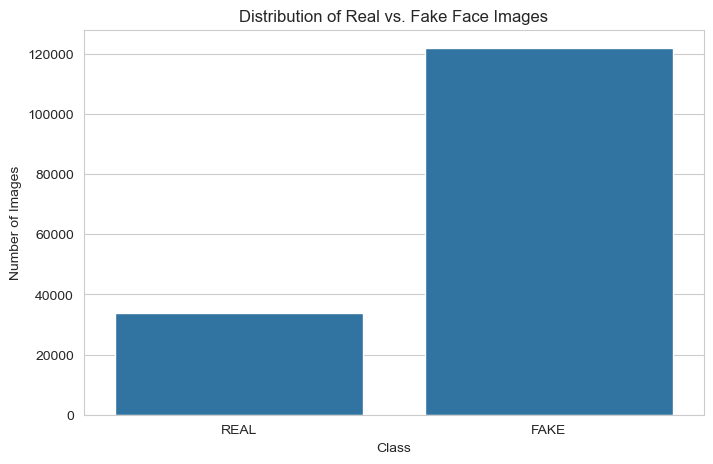

In [3]:
class_counts = df['label'].value_counts()
class_names = {0: 'REAL', 1: 'FAKE'}
df['label_name'] = df['label'].map(class_names)

print("Class Distribution:")
print(class_counts)

imbalance_ratio = class_counts[1] / class_counts[0]
print(f"\nImbalance Ratio (Fake/Real): {imbalance_ratio:.2f}:1")

plt.figure(figsize=(8, 5))
sns.countplot(x='label_name', data=df, order=['REAL', 'FAKE'])
plt.title('Distribution of Real vs. Fake Face Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## 3. Analyze Faces per Video

Let's see how many faces were extracted from each video. This can help us spot any outliers (e.g., videos where no faces were detected or an unusually high number were detected).

Statistics for number of faces extracted per video:
count    7152.000000
mean       21.771672
std         4.655975
min         1.000000
25%        15.000000
50%        25.000000
75%        25.000000
max        25.000000
Name: filename, dtype: float64


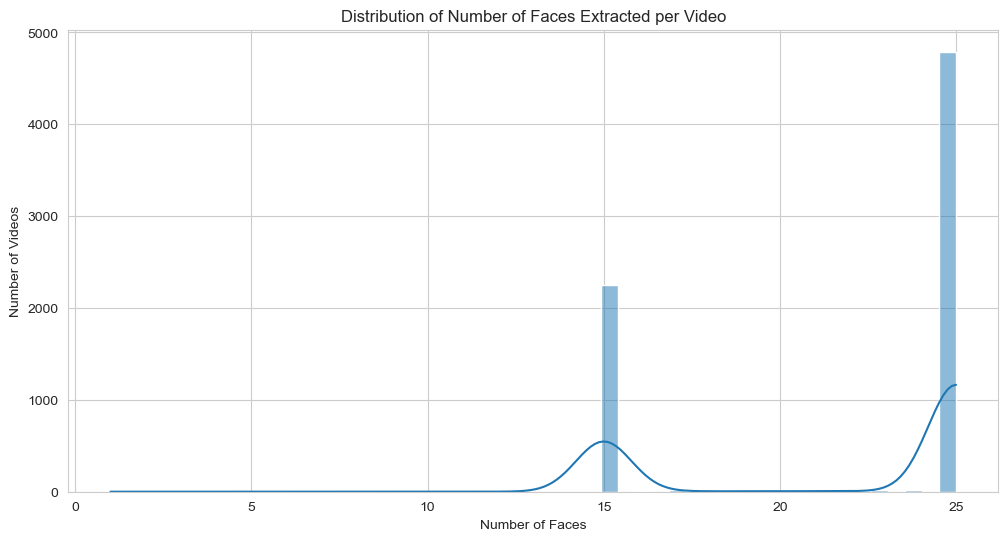

In [4]:
faces_per_video = df.groupby('video_name')['filename'].count()

print("Statistics for number of faces extracted per video:")
print(faces_per_video.describe())

plt.figure(figsize=(12, 6))
sns.histplot(faces_per_video, bins=50, kde=True)
plt.title('Distribution of Number of Faces Extracted per Video')
plt.xlabel('Number of Faces')
plt.ylabel('Number of Videos')
plt.show()

## 4. Visualize Sample Images

The most important validation step is to look at the images. Are the faces cropped correctly? Is the quality acceptable? Are there any obvious errors from the face detector?

In [5]:
def plot_samples(label, title, num_samples=10):
    """Helper function to plot random samples for a given class."""
    sample_df = df[df['label'] == label].sample(num_samples)
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    
    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(IMAGE_DIR, row.filename)
        try:
            img = Image.open(img_path)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{row.video_name[:10]}...\nFrame: {row.frame_number}")
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

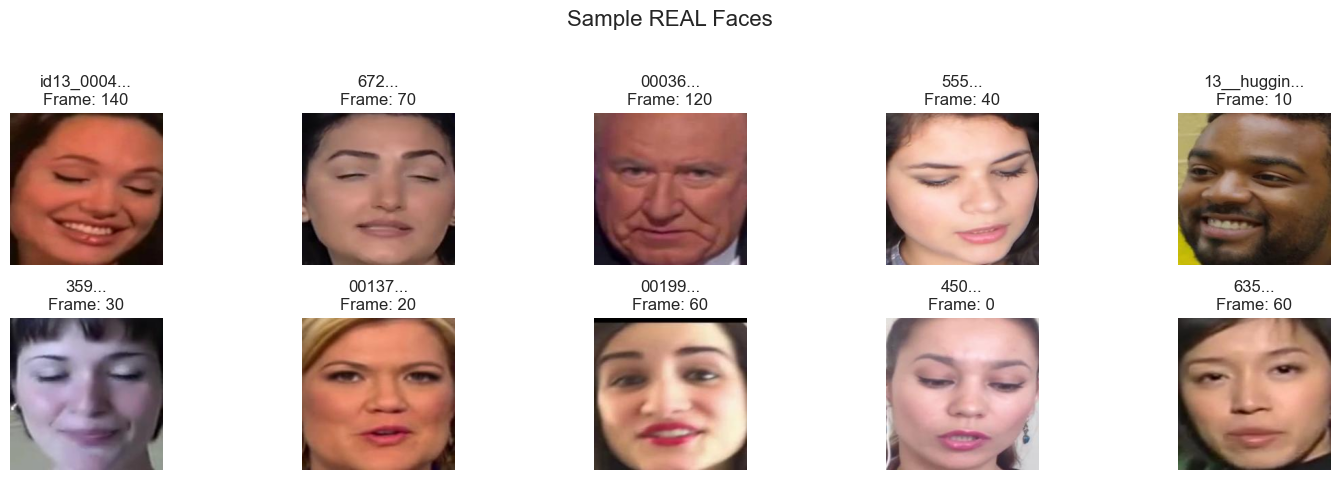

In [6]:
# Plot samples of REAL faces
plot_samples(label=0, title='Sample REAL Faces')

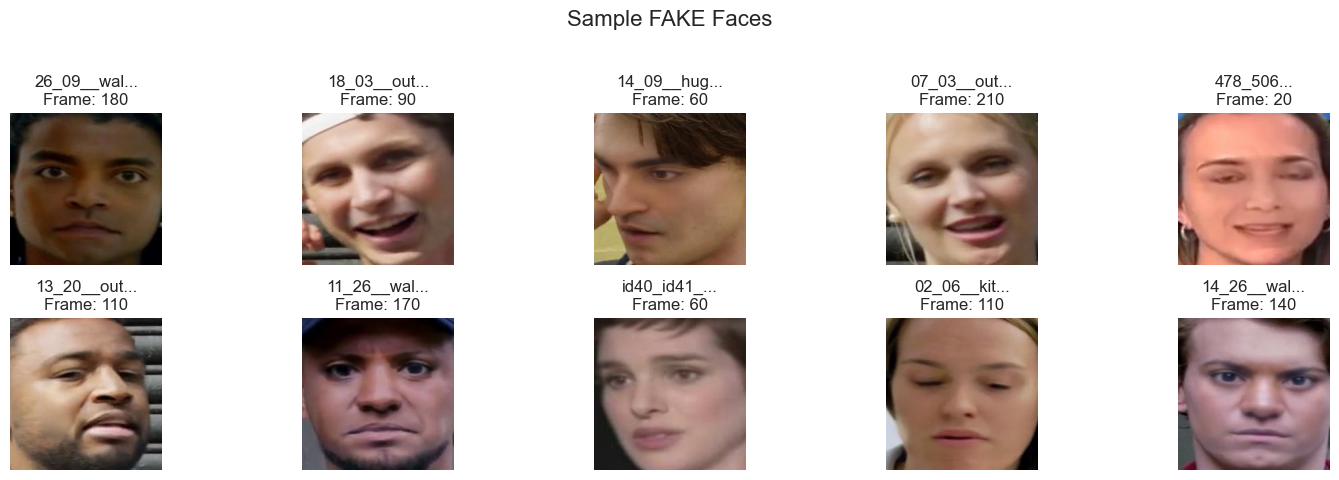

In [9]:
# Plot samples of FAKE faces
plot_samples(label=1, title='Sample FAKE Faces')

## Next Steps

Based on this exploration:
1. The class imbalance is confirmed and significant. We must address this during training.
2. The face crops generally look good, validating our `preprocess_videos.py` script.
3. The dataset is ready for the next stage: building a PyTorch `Dataset` and `DataLoader`.